<a href="https://colab.research.google.com/github/Gan4x4/CV-HSE2019/blob/master/extra/Eye_blink_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Idea and this func grabbed from here:
# https://www.pyimagesearch.com/2017/04/24/eye-blink-detection-opencv-python-dlib/

from scipy.spatial import distance as dist

def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear



In [1]:
#But using Pytorch  based landmark detector
!pip install face-alignment

#Download sample video
# It's not very simple becouse lecturer walking and somtimese lower her eyes to laptop
!wget https://github.com/Gan4x4/CV-HSE2019/raw/master/data/stanford1.mp4

--2020-04-10 14:56:42--  https://github.com/Gan4x4/CV-HSE2019/raw/master/data/stanford1.mp4
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/Gan4x4/CV-HSE2019/master/data/stanford1.mp4 [following]
--2020-04-10 14:56:42--  https://media.githubusercontent.com/media/Gan4x4/CV-HSE2019/master/data/stanford1.mp4
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5404748 (5.2M) [application/octet-stream]
Saving to: ‘stanford1.mp4’

stanford1.mp4       100%[===================>]   5.15M  24.4MB/s    in 0.2s    

2020-04-10 14:56:43 (24.4 MB/s) - ‘stanford1.mp4’ saved [5404748/5404748]



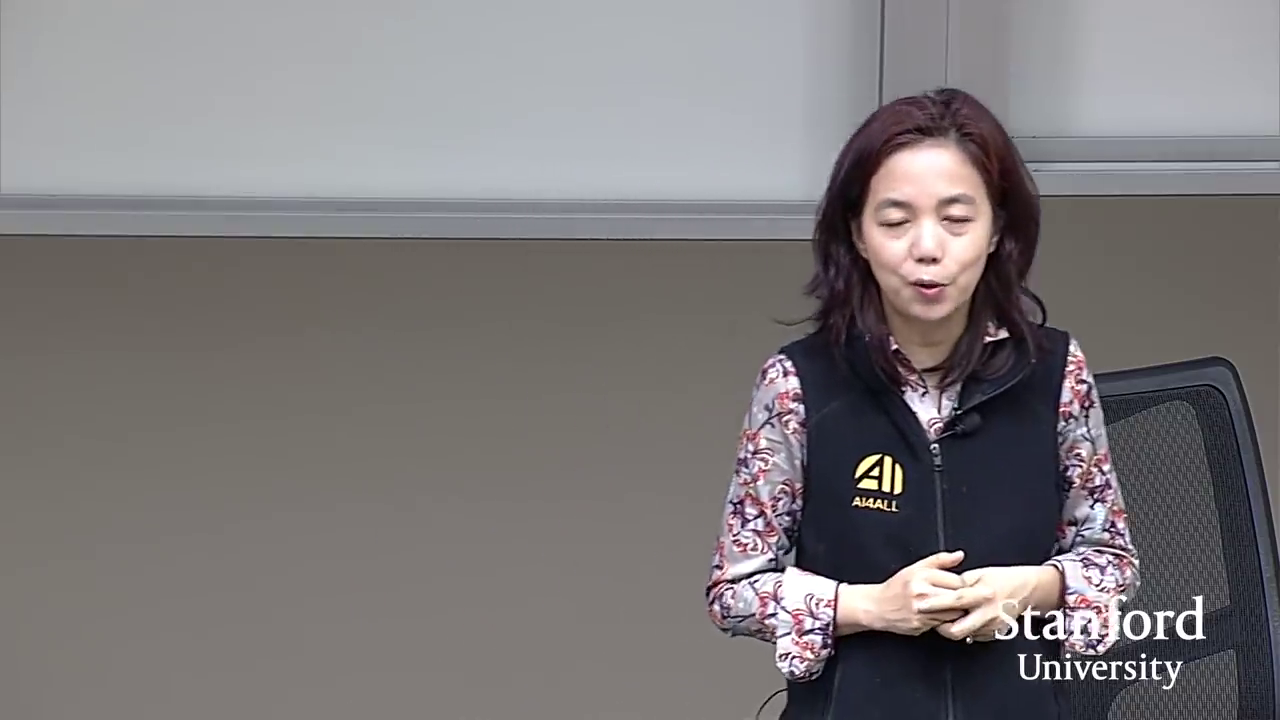

Blink at sec 2 
Processed 6% frames, 1 blinks detected 


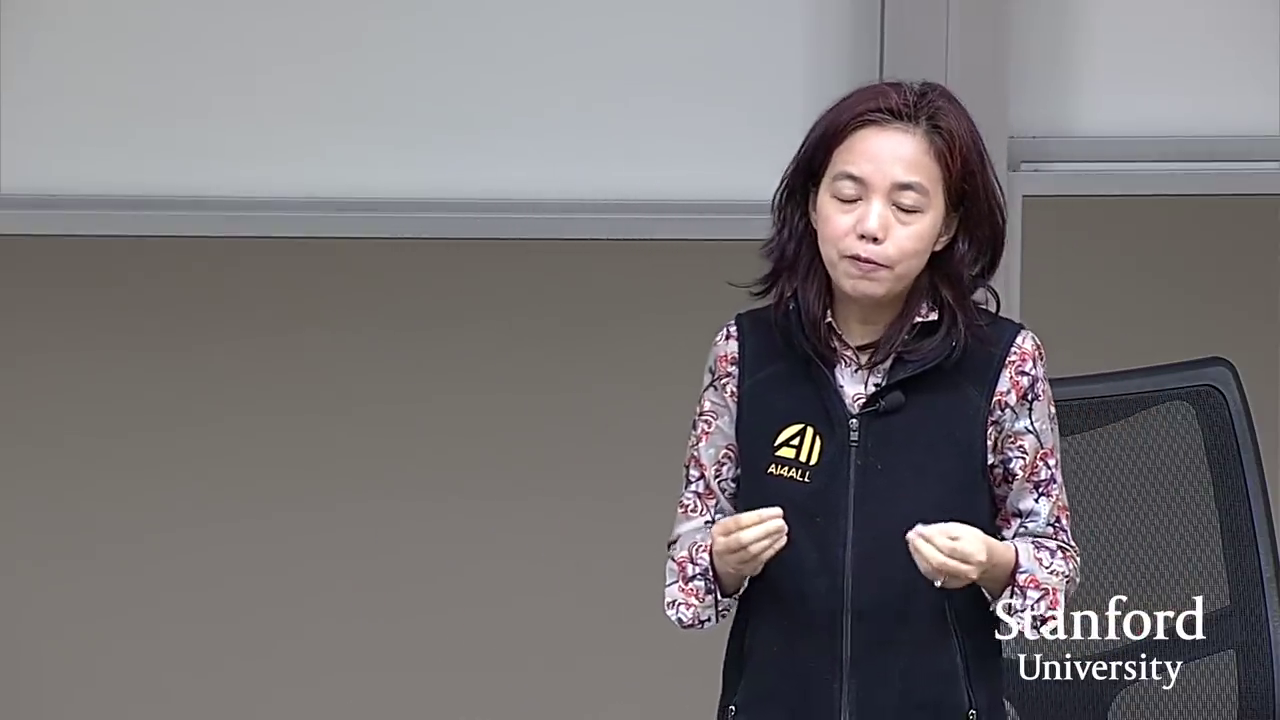

Blink at sec 3 


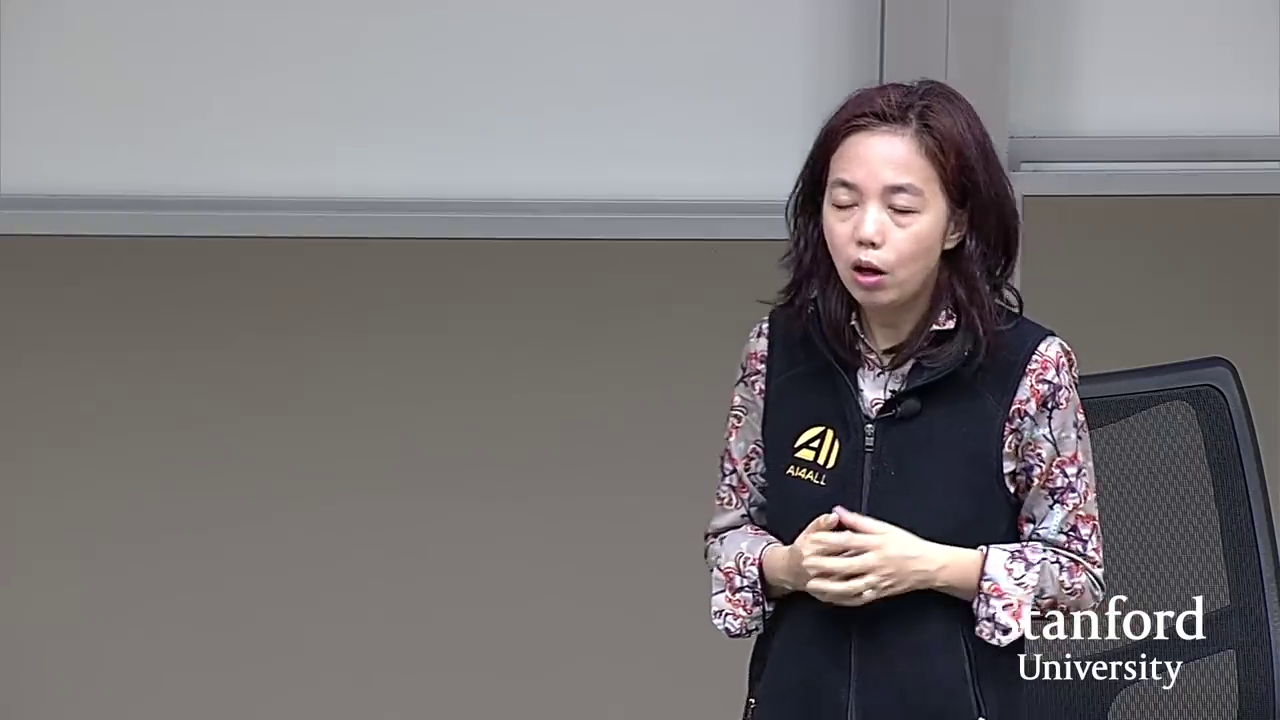

Blink at sec 5 
Processed 11% frames, 3 blinks detected 
Processed 17% frames, 3 blinks detected 


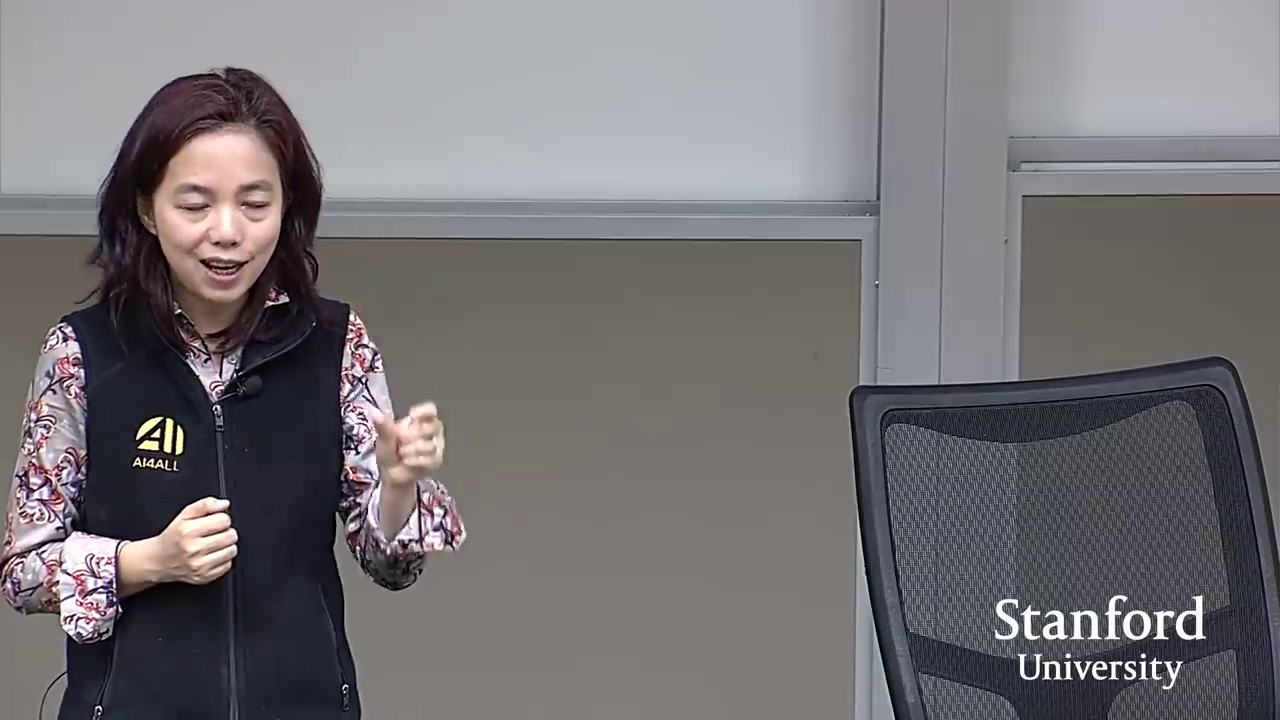

Blink at sec 11 


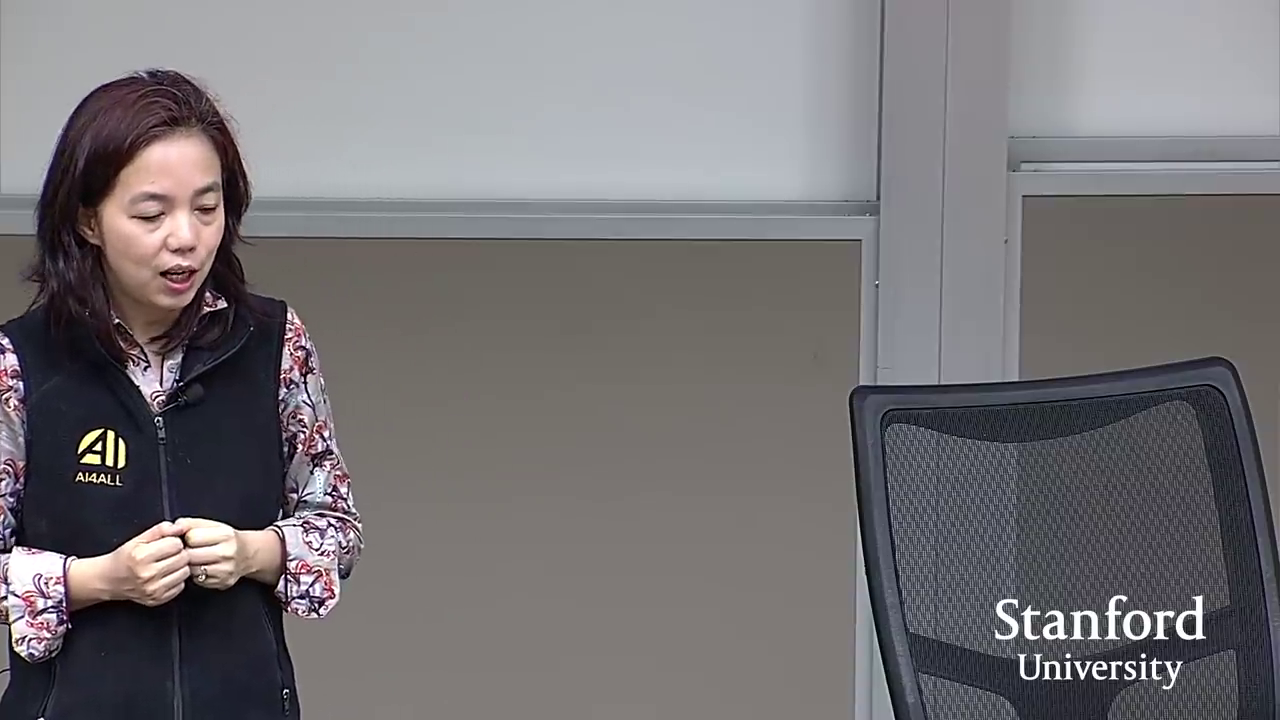

Blink at sec 12 


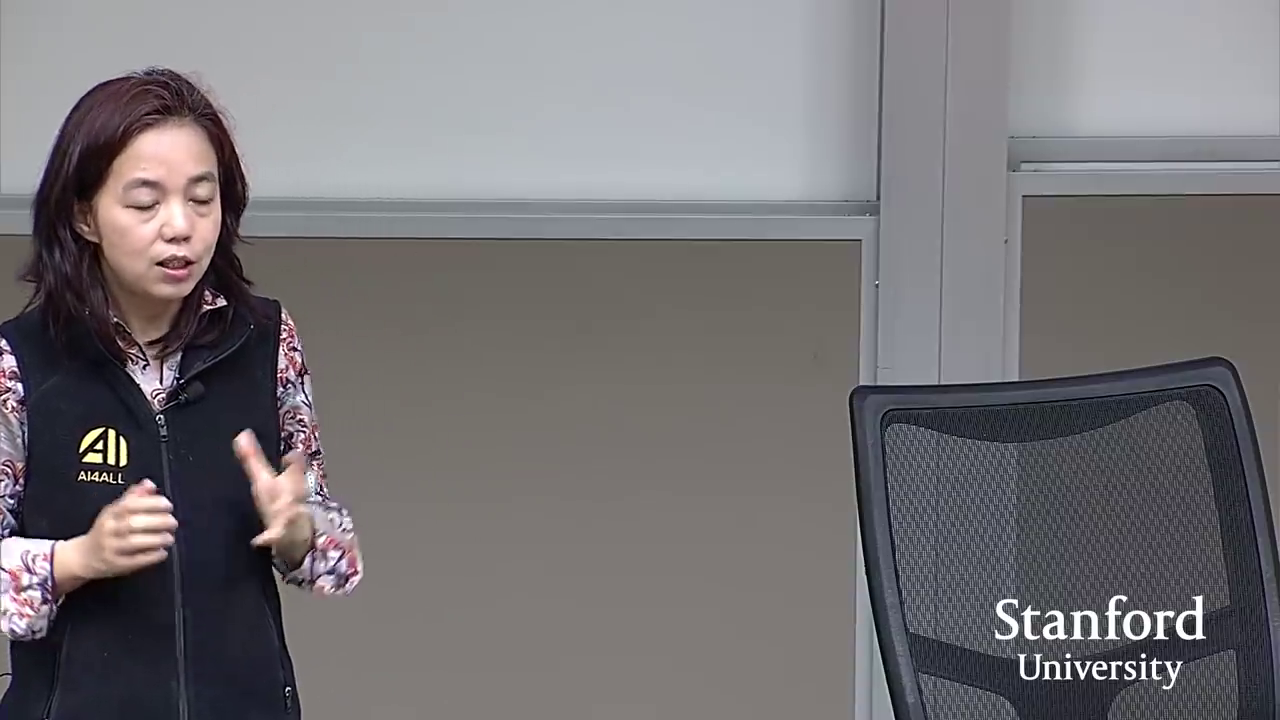

Blink at sec 13 
Processed 22% frames, 6 blinks detected 
Detected 6 blinks in total 


In [3]:
import face_alignment
import cv2
from google.colab.patches import cv2_imshow
import os

class BlinkDetector():
  OPENED = 1
  CLOSED = 2
  def __init__(self):
    self.state = BlinkDetector.OPENED
    self.time_threshold = 3 # In real life must depend on video FPS
    self.aspect_threshold = 0.22
    self.tic = 0
    self.blinks = 0

  def update(self,aspect):
    self.tic +=1
    if aspect > self.aspect_threshold:
      new_state = BlinkDetector.OPENED
    else:
      new_state = BlinkDetector.CLOSED

    if new_state != self.state:
      self.tic = 0
      self.state = new_state
   
    if self.tic == self.time_threshold and self.state == BlinkDetector.CLOSED:
      self.blinks +=1
      return True
    return False

fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
bd = BlinkDetector()

stream = cv2.VideoCapture("stanford1.mp4")
fps = stream.get(cv2.CAP_PROP_FPS)
length = stream.get(cv2.CAP_PROP_FRAME_COUNT)
i = 0
while stream.isOpened() and i/fps < 15: # stop after 15 sec
   ret, frame = stream.read() 
   if ret:
    landmarks = fa.get_landmarks(frame)
    if len(landmarks) > 0:
      right_eye = landmarks[0][42:48]
      left_eye = landmarks[0][36:42]
      aspect = (eye_aspect_ratio(left_eye) + eye_aspect_ratio(right_eye)) /2
      if bd.update(aspect):
        cv2_imshow(frame)
        print ("Blink at sec {} ".format(int(i/fps)))
    i +=1
    if not i % 100: 
      print("Processed {:.0%} frames, {} blinks detected ".format(i/length, bd.blinks))
   else:
    break

print("Detected {} blinks in total ".format(bd.blinks))    
stream.release()